In [1]:
!pip install -q tf-models-official tensorflow-addons
!pip install -q tfimm

     |████████████████████████████████| 2.2 MB 15.8 MB/s 
     |████████████████████████████████| 1.1 MB 74.3 MB/s 
     |████████████████████████████████| 47.8 MB 1.2 MB/s 
     |████████████████████████████████| 352 kB 83.5 MB/s 
     |████████████████████████████████| 4.9 MB 51.7 MB/s 
     |████████████████████████████████| 636 kB 95.3 MB/s 
     |████████████████████████████████| 99 kB 12.6 MB/s 
     |████████████████████████████████| 43 kB 2.5 MB/s 
     |████████████████████████████████| 1.2 MB 59.3 MB/s 
     |████████████████████████████████| 90 kB 10.8 MB/s 
     |████████████████████████████████| 237 kB 95.9 MB/s 
     |████████████████████████████████| 462 kB 75.7 MB/s 
     |████████████████████████████████| 139 kB 13.9 MB/s 


In [3]:
from official.vision.image_classification.augment import RandAugment
from tensorflow.keras import layers
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import os
import tfimm

In [17]:
AUTO = tf.data.AUTOTUNE
BATCH_SIZE = 128
EPOCHS = 10
RESIZE_TO = 256
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 0.0005
SEED = 1 
NFOLD = 5
VAL_FOLD = 0
TEST_FOLD = 1

GCS_PATH = 'gs://kds-57f9ca82c6ece747fdb97da243e70f5c8414ca9cf66a8576e6c00740'
VERBOSE = 1
train = pd.read_csv('gdrive/MyDrive/whale/train.csv')
N_CLASSES = train.species.nunique()
TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train/train/*.png')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test/test/*.png')
STEPS_PER_EPOCH = len(TRAINING_FILENAMES)+len(TEST_FILENAMES) // BATCH_SIZE

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)
    
seed_everything(SEED)

In [ ]:
from IPython.display import clear_output

tpu = tf.distribute.cluster_resolver.TPUClusterResolver()

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

clear_output()    

In [21]:
train = pd.read_csv('gdrive/MyDrive/whale/train.csv')

encoder = LabelEncoder()
train['labels'] = encoder.fit_transform(train.species)

gkf  = GroupKFold(n_splits = NFOLD)
train['fold'] = -1
for fold, (train_idx, val_idx) in enumerate(gkf.split(train, groups = train.individual_id.tolist())):
    train.loc[val_idx, 'fold'] = fold

train.head(1)

,image,species,individual_id,labels,fold
0,00021adfb725ed.jpg,melon_headed_whale,cadddb1636b9,18,2


In [22]:
valid_paths = [GCS_PATH+'/train/train/'+x[0]+'.png' for x in train[train['fold'] == VAL_FOLD]['image'].str.split('.').values]
train_paths = [GCS_PATH+'/train/train/'+x[0]+'.png' for x in train[(train['fold'] != VAL_FOLD) & (train['fold'] != TEST_FOLD)]['image'].str.split('.').values]
test_paths = [GCS_PATH+'/train/train/'+x[0]+'.png' for x in train[train['fold'] == TEST_FOLD]['image'].str.split('.').values]

valid_labels = np.array(train[train['fold'] == VAL_FOLD]['labels']).reshape(-1,1)
train_labels = np.array(train[(train['fold'] != VAL_FOLD) & (train['fold'] != TEST_FOLD)]['labels']).reshape(-1,1)
test_labels = np.array(train[train['fold'] == TEST_FOLD]['labels']).reshape(-1,1)

In [23]:
def decode_img(path):
    file_bytes = tf.io.read_file(path)
    img = tf.image.decode_png(file_bytes, channels=3)
    img = tf.image.resize(img, [RESIZE_TO,RESIZE_TO])
    img = tf.cast(img, tf.float32) 
    return img

def load_dataset(filename, label):
    img = decode_img(filename)
    return img, label

In [24]:
train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
valid_ds = tf.data.Dataset.from_tensor_slices((valid_paths, valid_labels))
test_ds = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))

# This dataset will be used to train the first model.
train_ds = (
    train_ds.map(load_dataset, num_parallel_calls = AUTO)
    .cache()
    .shuffle(BATCH_SIZE * 10, seed=SEED)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(AUTO)
)

valid_ds = (
    valid_ds.map(load_dataset, num_parallel_calls = AUTO)
    .cache()
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

test_ds = (
    test_ds.map(load_dataset, num_parallel_calls = AUTO)
    .cache()
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

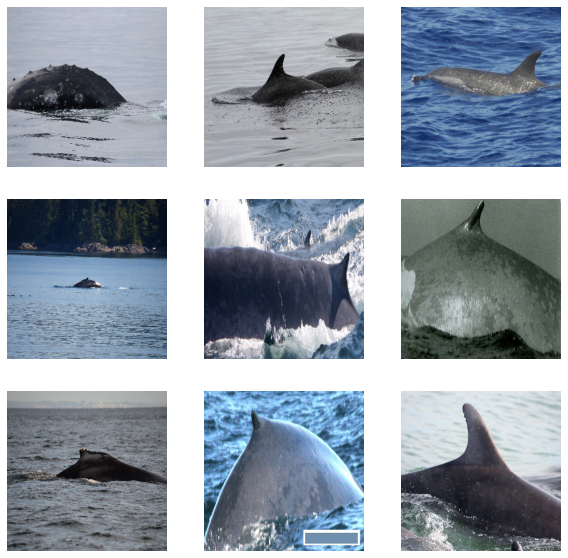

In [25]:
sample_images, sample_labels = next(iter(train_ds))
plt.figure(figsize=(10, 10))
for i, image in enumerate(sample_images[:9]):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("int"))
    plt.axis("off")

In [ ]:
def get_teacher_model(num_classes=N_CLASSES):
    model_ = tfimm.create_model('resnet50d')
    model = tf.keras.Sequential(
        [
            layers.Input((RESIZE_TO, RESIZE_TO, 3)),
            layers.Rescaling(scale=1.0 / 127.5, offset=-1),
            model_,
            layers.Dense(num_classes),
        ]
    )
    return model

def get_student_model(num_classes=N_CLASSES):
    model_ = tfimm.create_model('resnet34d')
    model = tf.keras.Sequential(
        [
            layers.Input((RESIZE_TO, RESIZE_TO, 3)),
            layers.Rescaling(scale=1.0 / 127.5, offset=-1),
            model_,
            layers.Dense(num_classes),
        ]
    )
    return model    

initial_teacher_model = get_teacher_model()
initial_teacher_model.save_weights("initial_teacher_model.h5")

initial_student_model = get_student_model()
initial_student_model.save_weights("initial_student_model.h5")

In [ ]:
# Define the callbacks.
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(patience=3)
early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=10, restore_best_weights=True
)

# Initialize SWA from tf-hub.
SWA = tfa.optimizers.SWA

# Compile and train the teacher model.

with strategy.scope():
  teacher_model = get_teacher_model()
  teacher_model.load_weights("initial_teacher_model.h5")
  teacher_model.compile(
    # Notice that we are wrapping our optimizer within SWA
    optimizer=SWA(tf.keras.optimizers.Adam(LEARNING_RATE)),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
    )
  
history = teacher_model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=valid_ds,
    callbacks=[reduce_lr, early_stopping], 
)

Epoch 1/10
239/239 [==============================] - 976s 4s/step - loss: 1.9315 - accuracy: 0.4953 - val_loss: 1.7855 - val_accuracy: 0.5204 - lr: 0.0010
Epoch 2/10
239/239 [==============================] - 34s 142ms/step - loss: 1.0835 - accuracy: 0.6714 - val_loss: 1.0059 - val_accuracy: 0.6965 - lr: 0.0010
Epoch 3/10
239/239 [==============================] - 32s 135ms/step - loss: 0.7987 - accuracy: 0.7540 - val_loss: 1.0231 - val_accuracy: 0.6952 - lr: 0.0010
Epoch 4/10
239/239 [==============================] - 32s 135ms/step - loss: 0.6401 - accuracy: 0.7998 - val_loss: 1.0509 - val_accuracy: 0.7018 - lr: 0.0010
Epoch 5/10
239/239 [==============================] - 34s 142ms/step - loss: 0.5274 - accuracy: 0.8337 - val_loss: 0.6824 - val_accuracy: 0.7952 - lr: 0.0010
Epoch 6/10
239/239 [==============================] - 34s 142ms/step - loss: 0.4398 - accuracy: 0.8599 - val_loss: 0.6696 - val_accuracy: 0.8057 - lr: 0.0010
Epoch 7/10
239/239 [==============================] - 

In [ ]:
class Distiller(keras.Model):
    def __init__(self, student, teacher):
        super(Distiller, self).__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=3,
    ):
        """ Configure the distiller.

        Args:
            optimizer: Keras optimizer for the student weights
            metrics: Keras metrics for evaluation
            student_loss_fn: Loss function of difference between student
                predictions and ground-truth
            distillation_loss_fn: Loss function of difference between soft
                student predictions and soft teacher predictions
            alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
            temperature: Temperature for softening probability distributions.
                Larger temperature gives softer distributions.
        """
        super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        # Unpack data
        x, y = data

        # Forward pass of teacher
        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predictions = self.student(x, training=True)

            # Compute losses
            student_loss = self.student_loss_fn(y, student_predictions)
            distillation_loss = self.distillation_loss_fn(
                tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                tf.nn.softmax(student_predictions / self.temperature, axis=1),
            )
            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"loss": loss}
        )
        return results

    def test_step(self, data):
        # Unpack the data
        x, y = data

        # Compute predictions
        y_prediction = self.student(x, training=False)

        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"loss": student_loss})
        return results

In [ ]:
# Initialize and compile distiller
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.5, monitor="val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=10, restore_best_weights=True, monitor="val_accuracy"
)

with strategy.scope():
  
  student_model = get_student_model()
  student_model.load_weights("initial_student_model.h5")

  distiller = Distiller(student=student_model, teacher=teacher_model)
  distiller.compile(
    optimizer=keras.optimizers.Adam(LEARNING_RATE),
    metrics=["accuracy"],
    student_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE),
    distillation_loss_fn=keras.losses.KLDivergence(reduction=tf.keras.losses.Reduction.NONE),
    alpha=0.1,
    temperature=10,
    )

# Distill teacher to student
distiller.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=valid_ds,
    callbacks=[reduce_lr, early_stopping],
)

Epoch 1/10
239/239 [==============================] - 103s 214ms/step - accuracy: 0.5492 - loss: 0.2550 - val_accuracy: 0.5827 - val_loss: 1.3279 - lr: 0.0010
Epoch 2/10
239/239 [==============================] - 35s 145ms/step - accuracy: 0.7290 - loss: 0.1408 - val_accuracy: 0.7382 - val_loss: 1.7755 - lr: 0.0010
Epoch 3/10
239/239 [==============================] - 31s 131ms/step - accuracy: 0.8123 - loss: 0.0976 - val_accuracy: 0.7379 - val_loss: 1.1868 - lr: 0.0010
Epoch 4/10
239/239 [==============================] - 34s 144ms/step - accuracy: 0.8579 - loss: 0.0772 - val_accuracy: 0.8141 - val_loss: 0.9817 - lr: 0.0010
Epoch 5/10
239/239 [==============================] - 34s 143ms/step - accuracy: 0.8877 - loss: 0.0607 - val_accuracy: 0.8498 - val_loss: 0.8382 - lr: 0.0010
Epoch 6/10
239/239 [==============================] - 32s 132ms/step - accuracy: 0.9096 - loss: 0.0502 - val_accuracy: 0.8366 - val_loss: 1.3413 - lr: 0.0010
Epoch 7/10
239/239 [==============================]

In [ ]:
with strategy.scope():
  
  student_model = get_student_model()
  student_model.load_weights("initial_student_model.h5")

  student_model.compile(
    optimizer=keras.optimizers.Adam(LEARNING_RATE),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
    )

# Train and evaluate student trained from scratch.
student_model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=valid_ds,
)

Epoch 1/10
239/239 [==============================] - 85s 168ms/step - loss: 1.5702 - accuracy: 0.5409 - val_loss: 1.4960 - val_accuracy: 0.5891
Epoch 2/10
239/239 [==============================] - 26s 107ms/step - loss: 0.9545 - accuracy: 0.7062 - val_loss: 1.1879 - val_accuracy: 0.6842
Epoch 3/10
239/239 [==============================] - 26s 107ms/step - loss: 0.6988 - accuracy: 0.7823 - val_loss: 0.8549 - val_accuracy: 0.7365
Epoch 4/10
239/239 [==============================] - 26s 108ms/step - loss: 0.5379 - accuracy: 0.8287 - val_loss: 0.8907 - val_accuracy: 0.7354
Epoch 5/10
239/239 [==============================] - 26s 108ms/step - loss: 0.4353 - accuracy: 0.8617 - val_loss: 0.7917 - val_accuracy: 0.7690
Epoch 6/10
239/239 [==============================] - 26s 108ms/step - loss: 0.3614 - accuracy: 0.8832 - val_loss: 0.5480 - val_accuracy: 0.8335
Epoch 7/10
239/239 [==============================] - 27s 114ms/step - loss: 0.2996 - accuracy: 0.9042 - val_loss: 0.6879 - val_ac

In [ ]:
_, t_acc = teacher_model.evaluate(test_ds, verbose=0)
d_acc, _ = distiller.evaluate(test_ds, verbose=0)
_, s_acc = student_model.evaluate(test_ds, verbose=0)

print(f"Test accuracy for teacher model: {t_acc*100}%")
print(f"Test accuracy for student model: {s_acc*100}%")
print(f"Test accuracy after distilling teacher to student: {d_acc*100}%")

Test accuracy for teacher model: 84.49103236198425%
Test accuracy for student model: 87.47918009757996%
Test accuracy after distilling teacher to student: 90.8690094947815%
